In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA,AutoETS,AutoTheta,AutoCES
from sklearn.metrics import mean_squared_error


In [16]:
def resample_fix_ends(pdf,frequency):
  """
  The function resamples the data according to the sampling frequency. 
  Often the first and the last data-point are deviating a lot from the rest of the series.
  
  As a simple fix i will just delete the first and the last value if they deviate more than 20% to their neighbour. 
  """

  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"

  for column in pdf.columns:
    if pdf[column].iloc[0] < 0.8*pdf[column].iloc[1]:
      pdf = pdf.drop(pdf.index[0]) 
      #pdf.at[pdf.index[0],column]   = pdf[column].iloc[1] #this would assigne the value of the next day to the first day.

    if pdf[column].iloc[-1] < 0.8*pdf[column].iloc[-2]:
      pdf = pdf.drop(pdf.index[-1]) 
      #pdf.at[pdf.index[-1],column]  = pdf[column].iloc[-2] #this would assigne the value of the second last day to the last day.

  return pdf

def reassign_outliers(pdf):
  """There is an extrem outlier in the data which is probably a mistake. I will reassign the value to it's neighbour."""

  for column in pdf.columns:
    
    outlier_loc = np.where(pdf[column] < np.mean(pdf[column])-3*np.std(pdf[column]))
    (pdf[column].values)[outlier_loc] = np.mean(pdf[column]) 

    print(f"Reassigned {len(outlier_loc)} values in the column {column}. These values where more than 3 sigma away from the mean.")

  return pdf


In [17]:
# url = "https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv"
# pdf = pd.read_csv(url,index_col=None)


pdf = pd.read_csv("../data/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf["Timestamp"] =  pd.to_datetime(pdf['Timestamp'],utc=True)
pdf = pdf.set_index(pdf["Timestamp"])
pdf = resample_fix_ends(pdf,"D")
pdf = reassign_outliers(pdf)

pdf.index = pdf.index.tz_localize(None)  #Let's drop the timezone info to avoid warnings

pdf["ds"] = pdf.index
pdf["unique_id"] = "test"
pdf = pdf.reset_index(drop=True)

pdf["y"] = (pdf["Value_NE5"].values + pdf["Value_NE7"].values)/1e6
pdf = pdf.drop(columns=["Value_NE5","Value_NE7"])

split = int(len(pdf)*0.9)
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

pdf

Reassigned 1 values in the column Value_NE5. These values where more than 3 sigma away from the mean.
Reassigned 1 values in the column Value_NE7. These values where more than 3 sigma away from the mean.


C:\Users\ewzbusi\AppData\Local\Temp\ipykernel_20876\3593820342.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pdf = pdf.resample(frequency).sum(min_count=1) #"D,W,M"


,ds,unique_id,y
0,2015-01-01,test,6.709087
1,2015-01-02,test,7.073348
2,2015-01-03,test,7.149544
3,2015-01-04,test,6.724467
4,2015-01-05,test,8.585045
...,...,...,...
3087,2023-06-15,test,7.271072
3088,2023-06-16,test,7.173852
3089,2023-06-17,test,6.233946
3090,2023-06-18,test,5.879637


In [18]:
# Define a list of models for forecasting
season_length = 7 
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length),   # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length),   # CES model with automatic seasonality detection
]


sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(pdf_train)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [19]:
y_pred = sf.predict(h=len(pdf_test)) 
y_pred.tail()

,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
test,2023-06-15,7.349135,7.179311,7.167984,7.776837
test,2023-06-16,7.283352,7.088421,7.087591,7.663156
test,2023-06-17,6.243016,6.252065,6.152145,6.757711
test,2023-06-18,5.767642,5.853499,5.714543,6.335415
test,2023-06-19,6.762673,7.035616,7.022914,7.585462


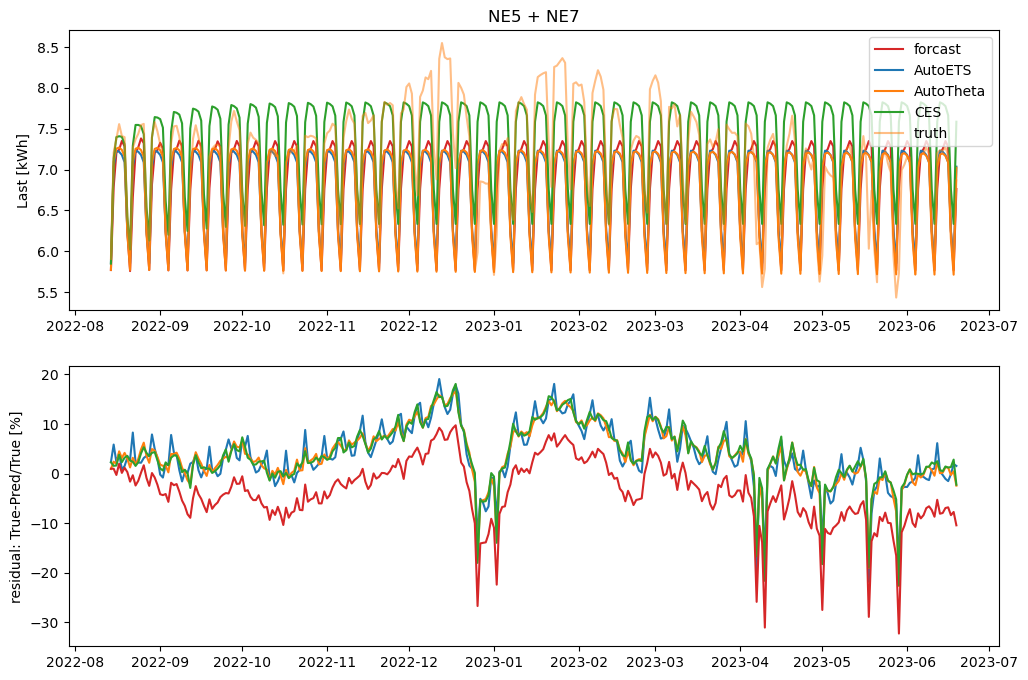

In [20]:

f, axes = plt.subplots(2, 1, figsize=(12, 8))


axes[0].plot(y_pred.ds.values, y_pred.AutoARIMA, color="tab:red", label="AutoARIMA")
axes[0].plot(y_pred.ds.values, y_pred.AutoETS, label="AutoETS")
axes[0].plot(y_pred.ds.values, y_pred.AutoTheta, label="AutoTheta")
axes[0].plot(y_pred.ds.values, y_pred.CES, label="CES")
# axes[0].plot(pdfTrain.ds.values, pdfTrain.y.values, color="tab:blue", label="train")
axes[0].plot(pdf_test.ds.values, pdf_test.y.values, color="tab:orange", label="truth", alpha=0.5)
axes[0].legend()
axes[0].set_title("NE5 + NE7")
axes[0].set_ylabel("Last [GWh]")


xmin, xmax = axes[0].get_xlim()

axes[1].plot(pdf_test.ds, (pdf_test.y.values - y_pred.AutoARIMA)/(pdf_test.y.values)*100)
axes[1].plot(pdf_test.ds, (pdf_test.y.values - y_pred.AutoETS)/(pdf_test.y.values)*100)
axes[1].plot(pdf_test.ds, (pdf_test.y.values - y_pred.AutoTheta)/(pdf_test.y.values)*100)
axes[1].plot(pdf_test.ds, (pdf_test.y.values - y_pred.CES)/(pdf_test.y.values)*100)
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylabel("residual: True-Pred/True [%]")

plt.show()

In [21]:
rmseAutoARIMA = mean_squared_error(pdf_test.y, y_pred.AutoARIMA, squared=False)
rmseAutoETS   = mean_squared_error(pdf_test.y, y_pred.AutoETS, squared=False)
rmseAutoTheta = mean_squared_error(pdf_test.y, y_pred.AutoTheta, squared=False)
rmseCES       = mean_squared_error(pdf_test.y, y_pred.CES, squared=False)

print(f"RMSE AutoARIMA: {rmseAutoARIMA}")
print(f"RMSE AutoETS: {rmseAutoETS}")
print(f"RMSE AutoTheta: {rmseAutoTheta}")
print(f"RMSE CES: {rmseCES}")

RMSE AutoARIMA: 0.531429103689258
RMSE AutoETS: 0.5191162827123288
RMSE AutoTheta: 0.5237888441818455
RMSE CES: 0.48778350199789317
